In [1]:
import pathlib
import os
from PIL import Image

import torch
from torchvision import models, datasets, transforms

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px

import pickle
from sklearn.decomposition import IncrementalPCA, PCA

In [2]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')
data_dir_val = pathlib.Path('../../data/skincancer_new_processed/val/images')

In [3]:
# read each image from the folder and convert it to a numpy array, center crop it and flatten it, add it to the dataset
def create_dataset(data_dir):
    index = []
    dataset = []
    path = data_dir
    for img in path.iterdir():
        index.append(str(img).split('/')[-1].split('.')[0])
        dataset.append(np.array(Image.open(img)))
    return dataset, index

In [4]:
dataset, index = create_dataset(data_dir_train)

In [5]:
dataset[0].shape

(128, 128, 3)

In [6]:
first_image = dataset[0]

In [7]:
first_image[:,:,0].shape

(128, 128)

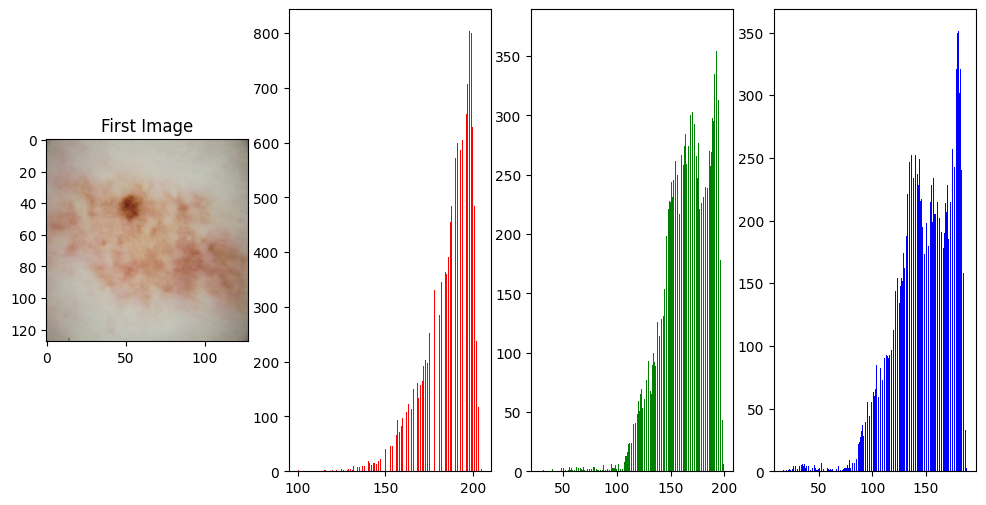

In [8]:
# create rgb histogram for the first image
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
ax[0].imshow(first_image)
ax[0].set_title('First Image')
ax[1].hist(first_image[:,:,0].flatten(), bins=255, color='r')
ax[2].hist(first_image[:,:,1].flatten(), bins=255, color='g')
ax[3].hist(first_image[:,:,2].flatten(), bins=255, color='b')
plt.show()

In [9]:
# get the 255 bins for each channel
r_hist = np.histogram(first_image[:,:,0].flatten(), bins=255, range=(0, 255))
g_hist = np.histogram(first_image[:,:,1].flatten(), bins=255, range=(0, 255))
b_hist = np.histogram(first_image[:,:,2].flatten(), bins=255, range=(0, 255))


In [10]:
r_hist[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   1,   0,   0,
         0,   0,   1,   0,   1,   0,   0,   0,   1,   1,   1,   2,   2,
         1,   0,   1,   3,   1,   2,   1,   7,   5,   2,   7,   2,   4,
         5,   3,  10,   4,   8,   7,  11,   9,  10,  14,  18,  15,  12,
        15,  16,  13,  18,  23,  25,  29,  41,  33,  32,  46,  46,  66,
        67,  94,  71,  82,  98, 104, 108, 122, 124, 114, 151, 176, 162,
       133, 158, 164, 193, 203, 197, 253, 261, 273, 330, 313, 31

In [11]:
# create a dataframe with the histograms values for each image
def create_histograms(dataset):
    histograms = []
    for img in dataset:
        r_hist = np.histogram(img[:,:,0].flatten(), bins=255, range=(0, 255))[0]
        g_hist = np.histogram(img[:,:,1].flatten(), bins=255, range=(0, 255))[0]
        b_hist = np.histogram(img[:,:,2].flatten(), bins=255, range=(0, 255))[0]
        histograms.append(np.concatenate([r_hist, g_hist, b_hist]))
    return histograms

In [12]:
hists = create_histograms(dataset)
hists

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   1,   0,   0,
          0,   0,   1,   0,   1,   0,   0,   0,   1,   1,   1,   2,   2,
          1,   0,   1,   3,   1,   2,   1,   7,   5,   2,   7,   2,   4,
          5,   3,  10,   4,   8,   7,  11,   9,  10,  14,  18,  15,  12,
         15,  16,  13,  18,  23,  25,  29,  41,  33,  32,  46,  46,  66,
         67,  94,  71,  82,  98, 104, 108, 122, 124, 114, 151, 176, 162,
        133, 158, 164, 193, 203, 197, 253, 261, 273

In [13]:
df_hists = pd.DataFrame(hists, index=index)
df_hists

0    1    2    3    4    5    6    7    8    9    ...  755  756  \
ISIC_0010093    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0010201    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0014929   57    0    1    0    0    0    1    1    1    2  ...    0    0   
ISIC_0008992    0    0    0    0    0    0    0    0    0    0  ...   82   57   
ISIC_0012671    0    0    0    0    0    0    0    0    0    0  ...    0    0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
ISIC_0010498    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0010479    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0013783    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0000364    0    0    0    0    0    0    0    0    0    0  ...    0    0   
ISIC_0012828    0    0    0    0    0    0    0    0    0    0  ...   17   14   

              757  758  759  760  761  762  763  764  
ISIC_0010093    0    0    0    0    0    0    0    0  
ISIC_0010201    0    0    0    0    0    0    0    0  
ISIC_0014929    0    0    0    0    0    0    0    0  
ISIC_0008992   44   23   22   23   16   12   11   20  
ISIC_0012671    0    0    0    0    0    0    0    0  
...           ...  ...  ...  ...  ...  ...  ...  ...  
ISIC_0010498    0    0    0    0    0    0    0    0  
ISIC_0010479    0    0    0    0    0    0    0    0  
ISIC_0013783    0    0    0    0    0    0    0    0  
ISIC_0000364    0    0    0    0    0    0    0    0  
ISIC_0012828   15    8    2    1    2    1    0    0  

[2000 rows x 765 columns]

In [14]:
# normalize the df_hists using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_hists_scaled = scaler.fit_transform(df_hists)
df_hists_scaled = pd.DataFrame(df_hists_scaled, index=index)
df_hists_scaled

0         1         2         3         4         5    \
ISIC_0010093 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0010201 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0014929  0.230890 -0.108986 -0.104524 -0.112961 -0.114825 -0.130749   
ISIC_0008992 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0012671 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
...                ...       ...       ...       ...       ...       ...   
ISIC_0010498 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0010479 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0013783 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0000364 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   
ISIC_0012828 -0.081268 -0.108986 -0.118258 -0.112961 -0.114825 -0.130749   

                   6         7         8         9    ...       755       756  \
ISIC_0010093 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0010201 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0014929 -0.080670 -0.079497 -0.080134 -0.008578  ... -0.164994 -0.155162   
ISIC_0008992 -0.124788 -0.132092 -0.150150 -0.140043  ...  2.287778  1.551392   
ISIC_0012671 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
...                ...       ...       ...       ...  ...       ...       ...   
ISIC_0010498 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0010479 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0013783 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0000364 -0.124788 -0.132092 -0.150150 -0.140043  ... -0.164994 -0.155162   
ISIC_0012828 -0.124788 -0.132092 -0.150150 -0.140043  ...  0.343508  0.263992   

                   757       758       759       760       761       762  \
ISIC_0010093 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0010201 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0014929 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0008992  1.164884  0.585095  0.511009  0.531845  0.027396  0.130957   
ISIC_0012671 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
...                ...       ...       ...       ...       ...       ...   
ISIC_0010498 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0010479 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0013783 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0000364 -0.151589 -0.150833 -0.148358 -0.144615 -0.057021 -0.117578   
ISIC_0012828  0.297209  0.105142 -0.088415 -0.115204 -0.046469 -0.096867   

                   763       764  
ISIC_0010093 -0.103552 -0.099764  
ISIC_0010201 -0.103552 -0.099764  
ISIC_0014929 -0.103552 -0.099764  
ISIC_0008992  0.021945 -0.052092  
ISIC_0012671 -0.103552 -0.099764  
...                ...       ...  
ISIC_0010498 -0.103552 -0.099764  
ISIC_0010479 -0.103552 -0.099764  
ISIC_0013783 -0.103552 -0.099764  
ISIC_0000364 -0.103552 -0.099764  
ISIC_0012828 -0.103552 -0.099764  

[2000 rows x 765 columns]

In [15]:
## apply PCA to the dataset
#pca = PCA(n_components=60)#, batch_size=500)
#pca.fit(df_hists_scaled)
#print(pca.explained_variance_ratio_)

In [16]:
#print(sum(pca.explained_variance_ratio_))

In [17]:
## confront the original image with the reconstructed image for a random image
#random_index = np.random.randint(0, len(dataset))
#random_image = dataset[random_index].reshape(1, -1)
#reconstructed_image = pca.inverse_transform(pca.transform(random_image))
#
#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(random_image.reshape(128, 128, 3))
#ax[0].set_title('Original Image')
#ax[0].axis('off')
#reconstructed_image_int = reconstructed_image.astype(int)
#ax[1].imshow(reconstructed_image_int.reshape(128, 128, 3))
#ax[1].set_title('Reconstructed Image')
#ax[1].axis('off')
#plt.show()

In [18]:
## save the pca model to a file
#with open('pca.pkl', 'wb') as f:
#    pickle.dump(pca, f)

In [19]:
#train = pca.transform(dataset)
#df_train = pd.DataFrame(train, index=index)
#df_train.index = [ind+"_train" for ind in index]
#df_train

In [20]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_train, x=0, y=1)
#fig.show()

In [21]:
## use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
#
## calculate the sum of squared distances for each number of clusters
#ssd = []
#silhouette = []
#for i in range(2, 16):
#    kmeans = KMeans(n_clusters=i, random_state=0)
#    kmeans.fit(df_train.values)
#    ssd.append(kmeans.inertia_)
#    silhouette.append(silhouette_score(df_train.values, kmeans.labels_))
#
## plot the sum of squared distances
#plt.plot(range(2, 16), ssd)
#plt.xlabel('Number of clusters')
#plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method')
#plt.show()
#
## plot the silhouette score
#plt.plot(range(2, 16), silhouette)
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score')   
#plt.show()
#
## use 3 clusters
#kmeans = KMeans(n_clusters=4, random_state=0)
#kmeans.fit(df_train.values)
#df_train['cluster'] = kmeans.labels_
#df_train['cluster'] = df_train['cluster'].astype(str)
#df_train

In [22]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_train, x=0, y=1, color='cluster')
#fig.show()

In [23]:
#df_train.to_csv('train_pca_red_skincancer.csv')

In [24]:
## reduce to 3D
#import pacmap
#mapper = pacmap.PaCMAP(n_components=2, n_neighbors=2)
#X = df_hists_scaled.values
#X_2d = mapper.fit_transform(X)
#
#df_train_2d = pd.DataFrame(X_2d, columns=['x', 'y'], index=df_hists_scaled.index)
#df_train_2d

In [25]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_train_2d, x='x', y='y')
#fig.show()

In [26]:
# reduce dimensionality a second time using UMAP, use 3 dimensions
import umap
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_hists_scaled.values)
embedding.shape

df_umap = pd.DataFrame(embedding, index=df_hists_scaled.index, columns=['x', 'y'])
df_umap

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


x          y
ISIC_0010093   7.060456  10.260043
ISIC_0010201   7.974813   9.142892
ISIC_0014929   8.634566   8.470374
ISIC_0008992   6.714842  11.966915
ISIC_0012671   6.863998  11.249706
...                 ...        ...
ISIC_0010498   8.336246   9.191968
ISIC_0010479   4.828215   9.695935
ISIC_0013783   2.998419   6.313507
ISIC_0000364   7.351011   5.553975
ISIC_0012828  11.476744   6.229426

[2000 rows x 2 columns]

In [27]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_umap, x='x', y='y')
fig.show()

In [28]:
#import trimap
#mapper = trimap.TRIMAP(n_dims=2)
#embedding = mapper.fit_transform(df_hists_scaled.values)
#embedding.shape
#
#df_trimap = pd.DataFrame(embedding, index=df_hists_scaled.index, columns=['x', 'y'])
#df_trimap

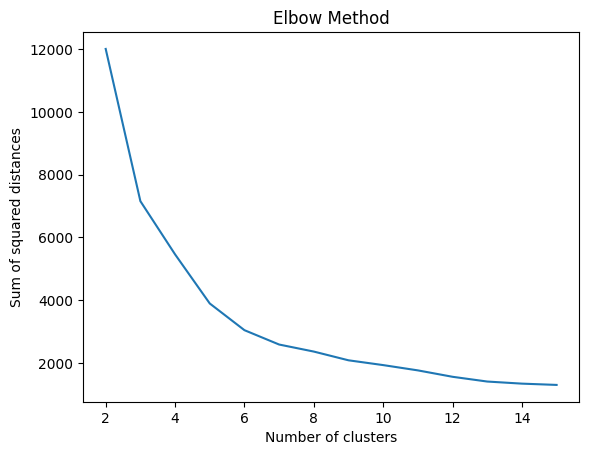

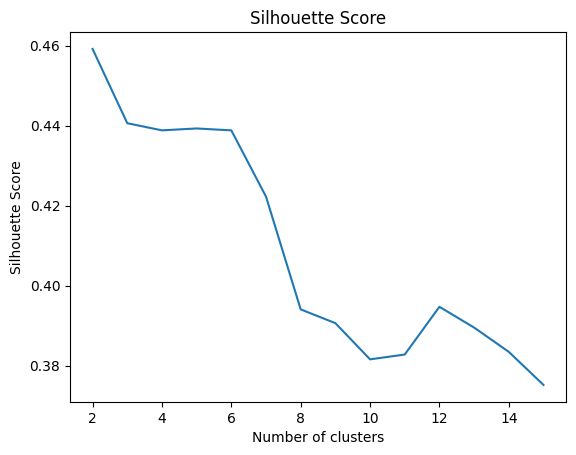

x          y cluster
ISIC_0010093   7.060456  10.260043       1
ISIC_0010201   7.974813   9.142892       1
ISIC_0014929   8.634566   8.470374       1
ISIC_0008992   6.714842  11.966915       1
ISIC_0012671   6.863998  11.249706       1
...                 ...        ...     ...
ISIC_0010498   8.336246   9.191968       1
ISIC_0010479   4.828215   9.695935       0
ISIC_0013783   2.998419   6.313507       0
ISIC_0000364   7.351011   5.553975       1
ISIC_0012828  11.476744   6.229426       1

[2000 rows x 3 columns]

In [29]:
# use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# calculate the sum of squared distances for each number of clusters
ssd = []
silhouette = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embedding)
    ssd.append(kmeans.inertia_)
    silhouette.append(silhouette_score(embedding, kmeans.labels_))

# plot the sum of squared distances
plt.plot(range(2, 16), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

# plot the silhouette score
plt.plot(range(2, 16), silhouette)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')   
plt.show()

# use 3 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embedding)
df_umap['cluster'] = kmeans.labels_
df_umap['cluster'] = df_umap['cluster'].astype(str)
df_umap

In [30]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_umap, x='x', y='y', color='cluster')
fig.show()

In [31]:
df_umap_one_hot  = pd.get_dummies(df_umap['cluster'], dtype=int)
df_umap_one_hot

0  1
ISIC_0010093  0  1
ISIC_0010201  0  1
ISIC_0014929  0  1
ISIC_0008992  0  1
ISIC_0012671  0  1
...          .. ..
ISIC_0010498  0  1
ISIC_0010479  1  0
ISIC_0013783  1  0
ISIC_0000364  0  1
ISIC_0012828  0  1

[2000 rows x 2 columns]

In [32]:
df_umap_one_hot.to_csv('train_umap_new_skincancer.csv')

In [33]:
dataset, index = create_dataset(data_dir_test)
hists = create_histograms(dataset)
df_hists = pd.DataFrame(hists, index=index)

In [34]:
df_hists_scaled = scaler.transform(df_hists)
df_hists_scaled = pd.DataFrame(df_hists_scaled, index=index)
embedding = reducer.transform(df_hists_scaled.values)

df_trimap = pd.DataFrame(embedding, index=df_hists_scaled.index, columns=['x', 'y'])
df_trimap['cluster'] = kmeans.predict(df_trimap.values)
df_trimap['cluster'] = df_trimap['cluster'].astype(str)
df_trimap

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



x         y cluster
ISIC_0016028  4.072565  9.328341       0
ISIC_0014944  7.998028  6.698797       1
ISIC_0015990  0.097175  6.280802       0
ISIC_0016057  0.399974  7.262648       0
ISIC_0015089  6.888435  6.032332       1
...                ...       ...     ...
ISIC_0015215  8.806915  9.124325       1
ISIC_0015142  8.721767  7.679781       1
ISIC_0016015  2.837521  8.102551       0
ISIC_0012722  2.220809  7.320320       0
ISIC_0013814  2.029447  7.970181       0

[600 rows x 3 columns]

In [35]:
fig = px.scatter(df_trimap, x='x', y='y', color='cluster')
fig.show()

In [36]:
df_trimap_one_hot  = pd.get_dummies(df_trimap['cluster'], dtype=int)
df_trimap_one_hot

0  1
ISIC_0016028  1  0
ISIC_0014944  0  1
ISIC_0015990  1  0
ISIC_0016057  1  0
ISIC_0015089  0  1
...          .. ..
ISIC_0015215  0  1
ISIC_0015142  0  1
ISIC_0016015  1  0
ISIC_0012722  1  0
ISIC_0013814  1  0

[600 rows x 2 columns]

In [37]:
df_trimap_one_hot.to_csv('test_umap_new_skincancer.csv')

In [38]:
df_tot = pd.concat([df_umap, df_trimap])
df_tot

x          y cluster
ISIC_0010093  7.060456  10.260043       1
ISIC_0010201  7.974813   9.142892       1
ISIC_0014929  8.634566   8.470374       1
ISIC_0008992  6.714842  11.966915       1
ISIC_0012671  6.863998  11.249706       1
...                ...        ...     ...
ISIC_0015215  8.806915   9.124325       1
ISIC_0015142  8.721767   7.679781       1
ISIC_0016015  2.837521   8.102551       0
ISIC_0012722  2.220809   7.320320       0
ISIC_0013814  2.029447   7.970181       0

[2600 rows x 3 columns]

In [39]:
fig = px.scatter(df_tot, x='x', y='y', color='cluster')
fig.show()